# Modifying Priors

by Sarah Blunt (2018)

Most often, you will use the `Driver` class to interact with `orbitize`. This class automatically reads your input file, creates all of the `orbitize` objects you need to run an orbit fit, and allows you to run the orbit fit. See the introductory OFTI and MCMC tutorials for examples of working with this class.

However, sometimes you will want to work with the underlying methods directly. Doing this gives you control over the functionality `Driver` executes automatically, and allows you more flexibility.

Modifying priors is an example of something you might want to use the underlying API for. This tutorial walks you through how to do that. 

**Goals of this tutorial**:
- Learn to modify priors in `orbitize`
- Learn about the structure of the `orbitize` code base

In [1]:
from matplotlib import pyplot as plt
import orbitize
from orbitize import read_input, system, priors, sampler

## Read in Data

First, let's read in our data table. This is accomplished with `orbitize.read_input`:

In [2]:
data_table = read_input.read_formatted_file('{}/GJ504.csv'.format(orbitize.DATADIR))

print(data_table)

    epoch      object quant1 quant1_err quant2 quant2_err quant_type
-------------- ------ ------ ---------- ------ ---------- ----------
      55645.95      1 2479.0       16.0 327.94       0.39      seppa
      55702.89      1 2483.0        8.0 327.45       0.19      seppa
     55785.015      1 2481.0       33.0 326.84       0.94      seppa
     55787.935      1 2448.0       24.0 325.82       0.66      seppa
55985.19400184      1 2483.0       15.0 326.46       0.36      seppa
56029.11400323      1 2487.0        8.0 326.54       0.18      seppa
56072.30200459      1 2499.0       26.0 326.14       0.61      seppa


/Users/bluez3303/miniconda3/envs/python3.6/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecatedWarning: read_formatted_file is deprecated as of 1.0.2 and will be removed in 2.0. Use read_file() instead. v1.0.2 replaces read_formatted_file and read_orbitize_input with read_file(). For now, this will be a wrapper for read_file and will be removed in the v2.0 release.
  if __name__ == '__main__':


## Initialize `System` Object

Next, we initialize an `orbitize.system.System` object. This object stores information about the system you're fitting, such as your data, the total mass, and the parallax.

In [3]:
# number of secondary bodies in system
num_planets = 1

# total mass & error [msol]
system_mass = 1.22
mass_err = 0.08 

# parallax & error[mas]
plx = 56.95
plx_err = 0

sys = system.System(
    num_planets, data_table, system_mass, 
    plx, mass_err=mass_err, plx_err=plx_err
)

The `System` object has a few handy attributes to help you keep track of your fitting parameters. `System.labels` is a list of the names of your fit parameters, and `System.sys_priors` is a list of the priors on each parameter. Notice that the "prior" on parallax (`plx`) is just a float. That's because we fixed this parameter at the printed value by specifying that `plx_err`=0.

Finally, `System.param_idx` is a dictionary that maps the parameter names from `System.labels` to their indices in `System.sys_priors`.

In [4]:
print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'epp1', 'plx', 'mtot']
[Jeffreys, Uniform, Sine, Uniform, Uniform, Uniform, 56.95, Gaussian]
{'ecc1': 1, 'plx': 6, 'pan1': 4, 'sma1': 0, 'mtot': 7, 'epp1': 5, 'aop1': 3, 'inc1': 2}


## Explore & Modify Priors

Priors in `orbitize` are Python objects. You can view an exhaustive list [here](https://orbitize.readthedocs.io/en/latest/priors.html). Let's print out the attributes of some of our priors:

In [5]:
print(vars(sys.sys_priors[lab['ecc1']]))
print(vars(sys.sys_priors[lab['sma1']]))

{'minval': 0.0, 'maxval': 1.0}
{'logmax': 4.605170185988092, 'minval': 0.1, 'logmin': -2.3025850929940455, 'maxval': 100.0}


Check out the priors documentation (linked above) for more info about the attributes of each of these priors.

Now that we understand how priors are represented and where they are stored, we can modify them! Here's an example of changing the prior on eccentricity from the current uniform prior to a Gaussian prior:

In [6]:
mu = 0.2
sigma = 0.05

sys.sys_priors[lab['ecc1']] = priors.GaussianPrior(mu, sigma)

print(sys.labels)
print(sys.sys_priors)
print(vars(sys.sys_priors[lab['ecc1']]))

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'epp1', 'plx', 'mtot']
[Jeffreys, Gaussian, Sine, Uniform, Uniform, Uniform, 56.95, Gaussian]
{'sigma': 0.05, 'mu': 0.2}


## Run OFTI

All right! We're in business. To finish up, I'll demonstrate how to run an orbit fit with our modified `System` object, first with OFTI, then with MCMC.

Text(0,0.5,'number of orbits')

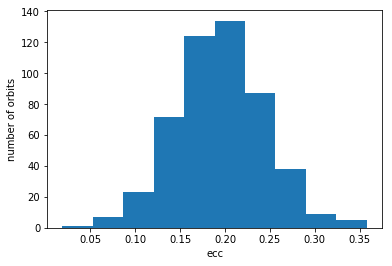

In [7]:
ofti_sampler = sampler.OFTI(sys)

# number of orbits to accept
n_orbs = 500

_ = ofti_sampler.run_sampler(n_orbs)

accepted_eccentricities = ofti_sampler.results.post[:, lab['ecc1']]
plt.hist(accepted_eccentricities)
plt.xlabel('ecc'); plt.ylabel('number of orbits')

## Run MCMC

Burn in complete


/Users/bluez3303/miniconda3/envs/python3.6/lib/python3.5/site-packages/orbitize/priors.py:156: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/bluez3303/miniconda3/envs/python3.6/lib/python3.5/site-packages/orbitize/priors.py:262: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Run complete


Text(0,0.5,'number of orbits')

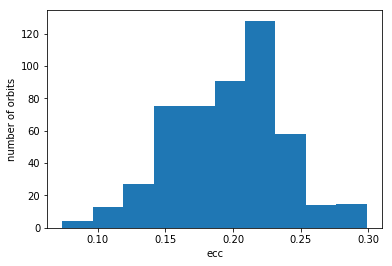

In [8]:
# number of temperatures & walkers for MCMC
num_temps = 3
num_walkers = 50

# number of steps to take
n_orbs = 500

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers)

# number of orbits to accept
n_orbs = 500

_ = mcmc_sampler.run_sampler(n_orbs)

accepted_eccentricities = mcmc_sampler.results.post[:, lab['ecc1']]
plt.hist(accepted_eccentricities)
plt.xlabel('ecc'); plt.ylabel('number of orbits')